In [34]:
%load_ext autoreload
%autoreload 2

import sys
if ".." not in sys.path:
  sys.path.append("..")
if 'google.colab' in sys.modules:
  from google.colab import drive
  drive.mount('/content/drive')
  os.chdir('/content/drive/MyDrive/coin-wear-estimator/')
  !pip3 install -r $ROOT_PATH/requirements.txt --quiet
  os.chdir('./notebook')

import itertools
import numpy as np
import cv2
from matplotlib import pyplot as plt
import itertools
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter
import numpy as np
import pandas as pd
from src.utils import *
from src.detector import crop_coin, create_circular_mask
from PIL import Image
import os
import pandas as pd
from tqdm.notebook import tqdm
from src.master_coin_utils import get_design_mask, get_wear_marks, generate_general_master_coin
from src.image_utils import remove_illumination
# from tqdm import tqdm
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data exploration

In [61]:
def calculate_sizes(root, csv_path):
    names = [name for name in os.listdir(root) if name.split(".")[-1] == "jpg"]
    names = sorted(names)
    df = pd.DataFrame({"name": names, "size": None})

    pbar = tqdm(total=len(df))
    for i, row in df.iterrows():
        row["size"] = Image.open(root + "/" + row["name"]).size[0]
        pbar.update(1)
    df.to_csv(csv_path, index=None)
    pbar.close()

calculate_sizes(aligned_coins_path(NIEMCZYK_DATASET_PATH), size_aligned_path(NIEMCZYK_DATASET_PATH))
calculate_sizes(aligned_coins_path(MARCINIAK_DATASET_PATH), size_aligned_path(MARCINIAK_DATASET_PATH))

  0%|          | 0/898 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

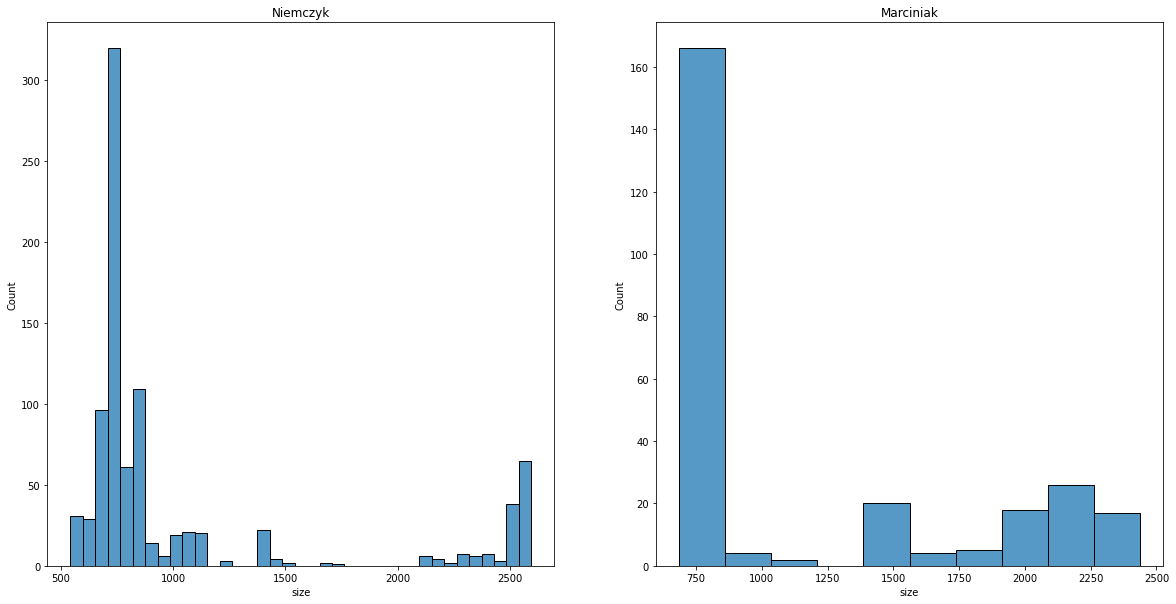

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))

for i, ds_path in enumerate([NIEMCZYK_DATASET_PATH, MARCINIAK_DATASET_PATH]):
  df = pd.read_csv(size_aligned_path(ds_path))
  sns.histplot(df["size"], ax=ax[i])

ax[0].set_title("Niemczyk")
ax[1].set_title("Marciniak")
plt.show()

# Master coin

In [57]:
# mc_1 = generate_general_master_coin(1)
# mc_2 = generate_general_master_coin(2)
# cv2.imwrite(master_coins_path(MARCINIAK_DATASET_PATH) + "/1_general.jpg", mc_1)
# cv2.imwrite(master_coins_path(MARCINIAK_DATASET_PATH) + "/2_general.jpg", mc_2)

mc_1 = cv2.imread(master_coins_path(MARCINIAK_DATASET_PATH) + "/1_general.jpg")
mc_2 = cv2.imread(master_coins_path(MARCINIAK_DATASET_PATH) + "/2_general.jpg")

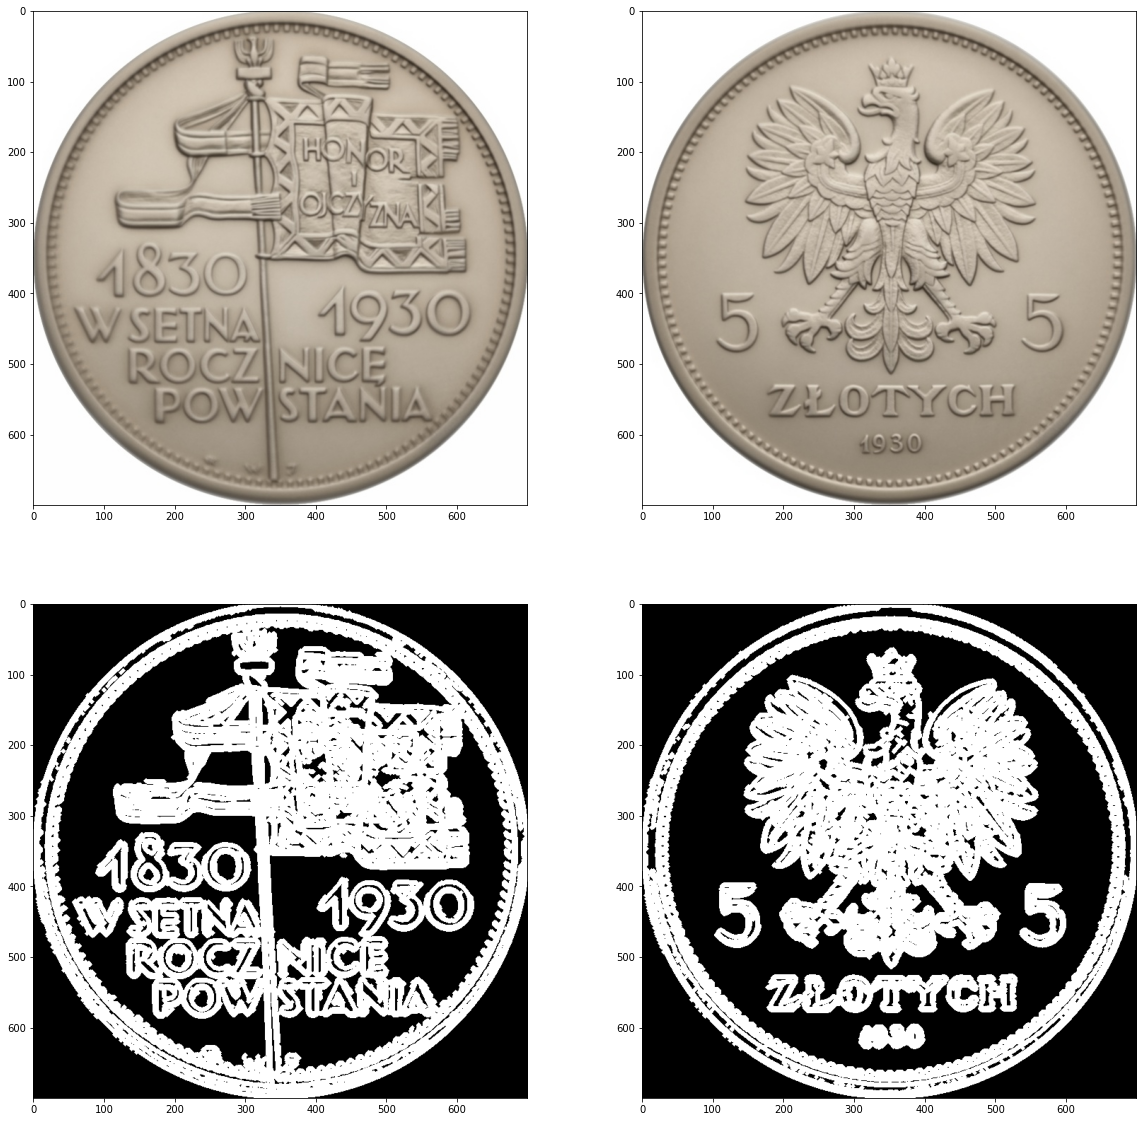

In [58]:
fig, ax = plt.subplots(2,2, figsize=(20,20))
ax = ax.flatten()

ax[0].imshow(cv2.cvtColor(mc_1, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(mc_2, cv2.COLOR_BGR2RGB))
ax[2].imshow(get_design_mask(mc_1), cmap='gray')
ax[3].imshow(get_design_mask(mc_2), cmap='gray')

plt.show()

plt.show()

# Wear marks

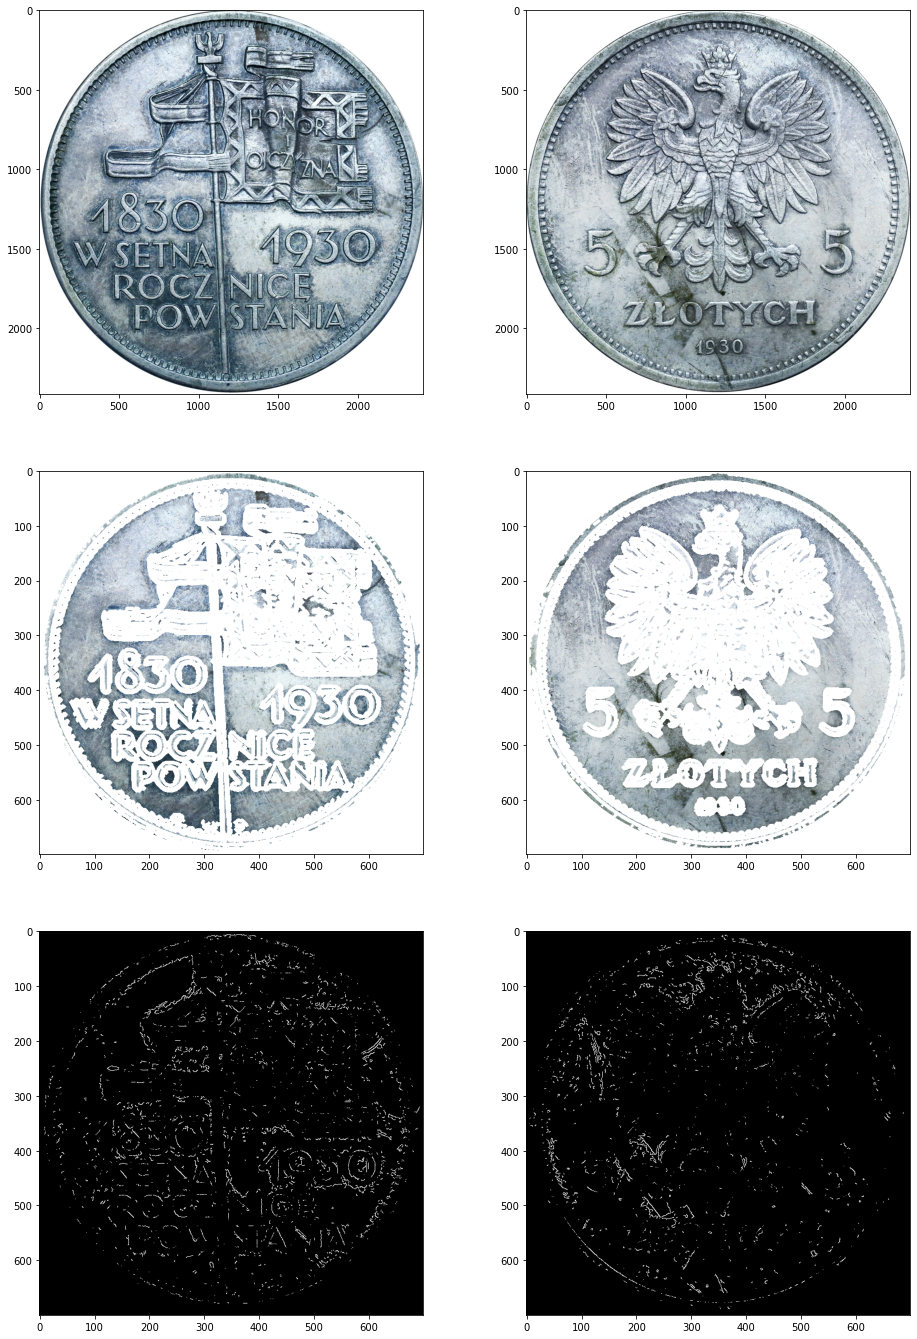

In [55]:
design_mask_1 = get_design_mask(mc_1)
design_mask_2 = get_design_mask(mc_2)

test_coin_1 = cv2.imread(aligned_coins_path(MARCINIAK_DATASET_PATH)+ '/2_3.jpg')
test_coin_2 = cv2.imread(aligned_coins_path(MARCINIAK_DATASET_PATH)+ '/2_2.jpg')

fig, ax = plt.subplots(3,2,figsize=(16,24))
ax = ax.flatten()

ax[0].imshow(test_coin_1, cmap='gray')
ax[1].imshow(test_coin_2, cmap='gray')

ax[2].imshow(get_wear_marks(test_coin_1, design_mask_1, canny_l=None), cmap='gray')
ax[3].imshow(get_wear_marks(test_coin_2, design_mask_2, canny_l=None), cmap='gray')

ax[4].imshow(get_wear_marks(test_coin_1, design_mask_1), cmap='gray')
ax[5].imshow(get_wear_marks(test_coin_2, design_mask_2), cmap='gray')

plt.show()

# Illumination removing

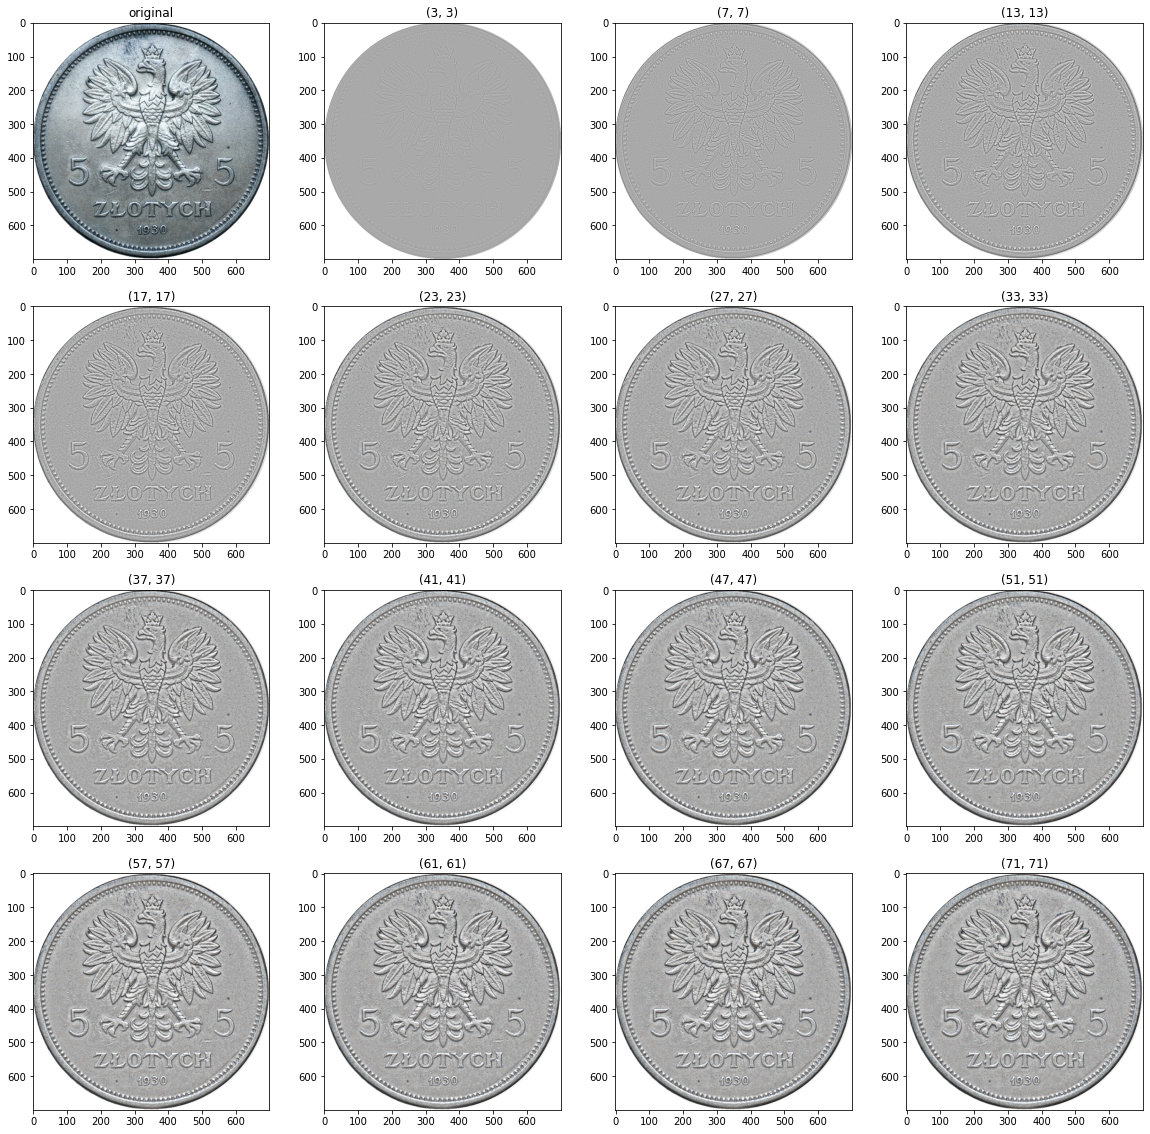

In [30]:
test_im = cv2.imread(aligned_coins_path(MARCINIAK_DATASET_PATH)+ '/1_2.jpg')
# test_im = cv2.cvtColor(test_im, cv2.COLOR_BGR2GRAY)
test_im = cv2.resize(test_im, (700,700))

fig, ax = plt.subplots(4,4,figsize=(20,20))
ax = ax.flatten()

ax[0].imshow(test_im, cmap='gray')
ax[0].set_title("original")
for i, s in enumerate(np.linspace(3, 71, 15)):
    s = int(s)
    if s % 2 == 0:
        s += 1 
    ax[i+1].imshow(remove_illumination(test_im, (s, s), 0), cmap='gray')
    ax[i+1].set_title("(%s, %s)" % (s, s))

plt.show()